In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os

# 1. Importando os Arquivos de Áudio

Importando 100 músicas de diferentes gêneros musicais. Dependendo do gênero musical identificado no diretório, já fazemos o rótulo que será utilizado posteriormente na predição.

In [2]:
GENRES = ['classical','hiphop']
num_lines = sum(1 for line in open('/kaggle/input/audio-path/audio_path.txt'))
num_lines

rotulos = []

file = open("/kaggle/input/audio-path/audio_path.txt", "r")
paths = []
for i, line in enumerate(file):
    
    for j, genre in enumerate(GENRES):
        if genre in line:
            rotulos.append(j)
            if (i < num_lines -1):
                paths.append(line[:-1])
            else:
               paths.append(line) 
    
paths = np.asarray(paths)
rotulos = np.asarray(rotulos)



In [3]:
def import_signal(path):
    s, sr = librosa.core.load(path)
    # slice em 660000 pois é o minimo de todos os audios
    return s[:660000]


signals = []

for p in paths:
    signals.append(import_signal(p))

signals = np.asarray(signals)


# 2. Transformada de Fourier de Curto Termo

**hop_length** : int > 0 [scalar] - Usamos 1024

    number of audio samples between adjacent STFT columns.

In [4]:
# return magnitude S
def stft(signal):
    S, phase = librosa.magphase(np.abs(librosa.stft(signal, hop_length=1024)))
    return S

signals_stft = []
for s in signals:
    signals_stft.append(stft(s))

signals_stft = np.asarray(signals_stft)
signals_stft.shape



(200, 1025, 645)

# 4. Features

In [5]:
def get_features(signals_stft, rotulos):
    def get_centroid(S):
        return librosa.feature.spectral_centroid(S=S)
    def get_flatness(S):
        return librosa.feature.spectral_flatness(S=S)
    def get_rms(s):
        return librosa.feature.rms(s, hop_length=1024)

    info = {'Centroid Mean':[], 
        'Centroid STD': [], 
        'Flatness Mean':[],
        'Flatness STD':[],
        'RMS':[],
        'Target': []} 

    
    for s, rotulo in zip(signals_stft, rotulos):
      
        info['Target'].append(rotulo)
        
        '''
            Obtendo centroide, flatness e RMS
        '''
        c = get_centroid(s)
        c = c[0]
        info['Centroid Mean'].append(np.mean(c))
        info['Centroid STD'].append(np.std(c))
        
        
        f = get_flatness(s)
        f = f[0]
        info['Flatness Mean'].append(np.mean(f))
        info['Flatness STD'].append(np.std(f))
        
        r = get_rms(s)
        r = round(r[0][0],3)
        info['RMS'].append(r)
        
        
        
    return pd.DataFrame(info)

In [6]:
df = get_features(signals_stft, rotulos)
df

,Centroid Mean,Centroid STD,Flatness Mean,Flatness STD,RMS,Target
0,1369.815653,417.092401,0.000428,0.000407,0.270,0
1,1079.923786,382.111172,0.000699,0.001171,0.073,0
2,1253.252933,241.370703,0.000569,0.000519,0.508,0
3,1179.890112,335.870810,0.000605,0.001549,0.111,0
4,1127.289993,352.918987,0.000602,0.000739,0.117,0
...,...,...,...,...,...,...
195,2343.619846,924.105877,0.029577,0.037983,2.373,1
196,3085.100354,778.406455,0.039486,0.038355,2.785,1
197,2433.040779,779.302227,0.017115,0.030176,2.104,1
198,2552.203926,1061.967549,0.034868,0.063767,0.417,1


# 6. Treinando o modelo

# 6.1 Normalizando os dados

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

X,y = df.iloc[:,0:-1], df['Target'].values
scaler.fit(X)
X = scaler.transform(X)

Dividindo o dataset em dados de treino e teste

In [9]:
# splitting the data into training and test sets (80:20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train[0])
print(y_train[0])



[-1.30515445 -1.31647098 -0.7021554  -0.67811451 -0.99398224]
0


# 6.2 Escolhendo o número k de vizinhos

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [11]:
#Try running from k=1 through 30 and record testing accuracy
k_range = range(1,31)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test,y_pred)
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

print(scores)


{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 0.975, 11: 1.0, 12: 0.975, 13: 0.975, 14: 0.975, 15: 0.975, 16: 0.975, 17: 0.975, 18: 0.975, 19: 0.975, 20: 0.975, 21: 0.975, 22: 0.975, 23: 0.975, 24: 0.975, 25: 0.975, 26: 0.925, 27: 0.975, 28: 0.925, 29: 0.975, 30: 0.95}


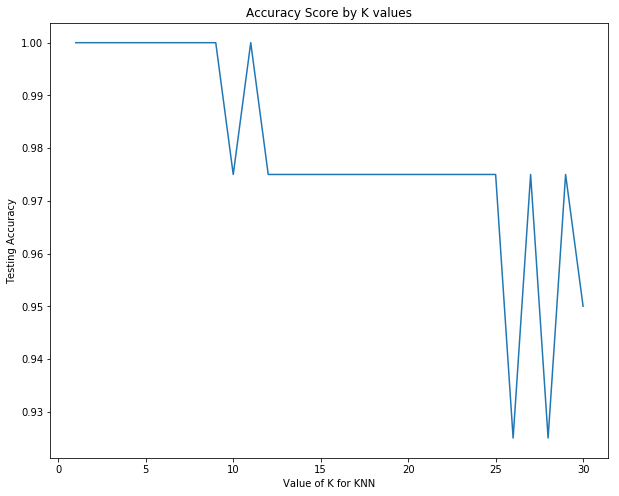

In [12]:
def plot_scores(x,y):
    fig, a = plt.subplots(1, figsize = (10, 8))
    title = "Accuracy Score by K values"
    plt.title(title)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Testing Accuracy')
    a.plot(x, y)
    
plot_scores(list(k_range), scores_list)

# 6.3 Treinando o modelo com k de maior acurácia

In [13]:
k = max(scores, key= scores.get)
print(k)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(y_pred)
metrics.accuracy_score(y_test,y_pred)

1
[0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1
 1 1 0]


1.0

In [14]:
from sklearn.decomposition import PCA
import pylab

[0.8372896  0.06726614]
[0.79328199 0.10033574]


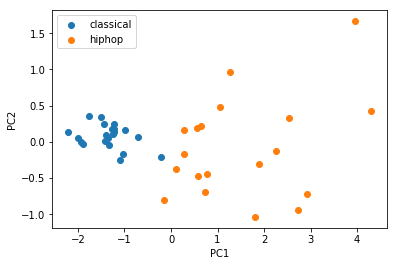

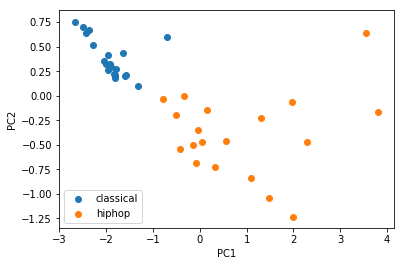

In [15]:
pca1 = PCA(2)
trans_pca1 = pca1.fit_transform(X_test)
print(pca1.explained_variance_ratio_)

pca2 = PCA(2)
pca2.fit(X_train)
trans_pca2 = pca2.transform(X_test)
print(pca2.explained_variance_ratio_)


for i, _ in enumerate(GENRES):
    pylab.scatter(trans_pca1[:,0][y_test==i], trans_pca1[:,1][y_test==i],cmap='jet',label=GENRES[i])
pylab.xlabel("PC1")
pylab.ylabel("PC2")
pylab.legend()
pylab.show()

for i, _ in enumerate(GENRES):
    pylab.scatter(trans_pca2[:,0][y_test==i], trans_pca2[:,1][y_test==i],cmap='jet',label=GENRES[i])
pylab.xlabel("PC1")
pylab.ylabel("PC2")
pylab.legend()
pylab.show()




E se utilizar o PCA no modelo de predição?

In [16]:
pca = PCA(2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(y_pred)
metrics.accuracy_score(y_test,y_pred)

[0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1
 1 1 0]


0.95

In [17]:
import seaborn as sns

In [18]:
trans_pca1 = pd.DataFrame(trans_pca1)
trans_pca1['Genres'] = [g for y in y_test for i, g in enumerate(GENRES) if y==i]
trans_pca1.columns = ['PC1', 'PC2', 'Genres']
trans_pca1.head()


,PC1,PC2,Genres
0,-1.097600,-0.248504,classical
1,-0.995230,0.166862,classical
2,-1.892526,-0.033422,classical
3,0.113304,-0.375544,hiphop
4,1.047575,0.484781,hiphop


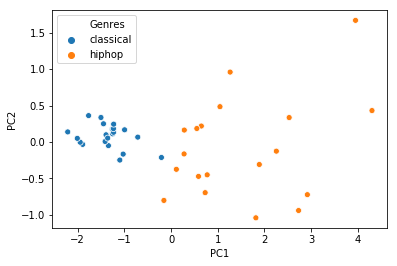

In [19]:
sns.scatterplot(x=trans_pca1['PC1'], y=trans_pca1['PC2'], hue=trans_pca1['Genres'])